In [52]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, spectrogram
import mne
from mne.preprocessing import ICA
sys.path.append('D:/capachinos')

In [53]:
from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor

participant_id = 1
vhdr_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.vhdr'
vmrk_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.vmrk'
eeg_path = r'D:\Anesthesia_Research_Fellow\CA-01\CA-01.eeg'

eeg_file = EEGFile(participant_id, vhdr_path, vmrk_path, eeg_path)
eeg_file.load_data()

#### Downsample, create epochs, bandpass filter the signal 

In [54]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
]
preprocessor.process(sequence_of_operations)

#### Z score the data, segment, reject nosiy segments, and concatenate to get a clean data

In [55]:
preprocessor.calculate_z_score()
preprocessor.get_segments(2)
preprocessor.mark_exclude_segments(min_channels=4)
preprocessor.concatenate_data_excluding_noisy_segments(padding = 'zeros')

#### Prototyping the apply_ica method
##### Analyzing and Filtering ICs: Signal Amplitude, Power Spectral Density, and Topographic Mapping

In [83]:
"""
Apply Independent Component Analysis (ICA) to the EEG data.
"""
data_attribute_to_process = 'eeg_with_rejected_noisy_segments'
epoch_name = 'emergence'

data_to_process = preprocessor._check_and_get_attribute(data_attribute_to_process)
data_to_process = data_to_process[epoch_name]

# Create an MNE Info object with the properties of your data
ch_names = preprocessor.channel_names  # Update with real channel names
ch_types = ['eeg'] * 16 + ['misc'] * (data_to_process.shape[1] - 16)
sampling_freq = preprocessor.ds_sampling_frequency if preprocessor.ds_sampling_frequency is not None else preprocessor.sampling_frequency
info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)

# Transpose your data to the shape `num_channels x num_samples` to create the Raw object
raw_data_transposed = data_to_process.T
raw = mne.io.RawArray(raw_data_transposed, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


# Fit ICA
ica = ICA(n_components=0.95, random_state=97)
ica.fit(raw)


# ica.exclude = [0]  # Put the indices of components associated with eye blinks

# # Apply ICA to the Raw object to remove the components
# raw_corrected = ica.apply(raw.copy())

# # Now you can convert the data back to the original format `num_samples x num_channels`
# preprocessor.corrected_eeg[epoch_name] = raw_corrected.get_data().T

Creating RawArray with float64 data, n_channels=21, n_times=984000
    Range : 0 ... 983999 =      0.000 ...  3935.996 secs
Ready.
Fitting ICA to data using 16 channels (please be patient, this may take a while)


C:\Users\Kourosh\AppData\Local\Temp\ipykernel_29052\3123273890.py:25: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by explained variance: 6 components
Fitting ICA took 21.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,33 iterations on raw data (984000 samples)
ICA components,6
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


##### Temporal signal analysis

Creating RawArray with float64 data, n_channels=6, n_times=984000
    Range : 0 ... 983999 =      0.000 ...  3935.996 secs
Ready.


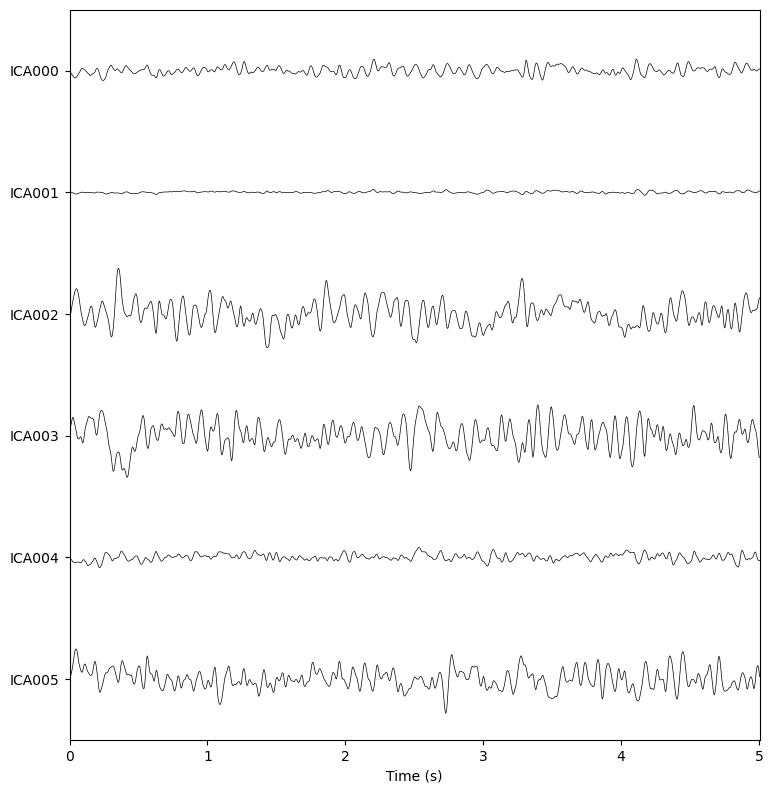

In [84]:
fig = ica.plot_sources(raw, show_scrollbars=False, start = 0, stop = 5, picks = None)

##### Power spectral density

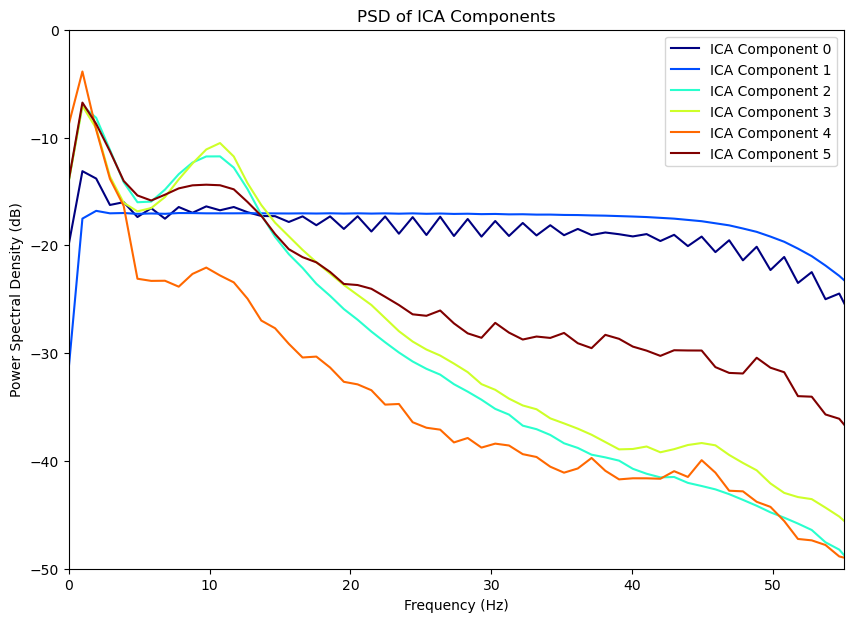

In [85]:
sources = ica.get_sources(raw).get_data().T

fig, ax = plt.subplots(figsize=[10, 7])
colors = plt.cm.jet(np.linspace(0, 1, sources.shape[1]))

for i in range(sources.shape[1]):
    freqs, psd = welch(sources[:, i], fs=sf, nperseg=256, noverlap=32) 
    ax.plot(freqs, 10 * np.log10(psd), label=f'ICA Component {i}', color=colors[i])

ax.set(title='PSD of ICA Components', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='best')
ax.set_xlim([0, 55])  
ax.set_ylim([-50, 0]) 
plt.show()

##### Time-frequency map (not functional)

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_29052\2021550413.py:8: RuntimeWarning: divide by zero encountered in log10
  Sxx_db = 10 * np.log10(Sxx)


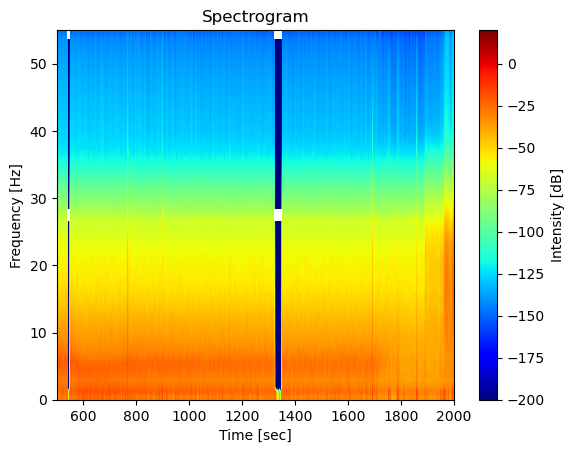

In [89]:
data_to_process = ica.get_sources(raw).get_data().T

frequencies, times, Sxx = spectrogram(data_to_process[:, 0], fs=sampling_freq, window='hann', 
                                                   nperseg=128, noverlap=64, detrend=False)

Sxx_db = 10 * np.log10(Sxx)

# Plot the spectrogram
plt.imshow(Sxx_db, aspect='auto', origin='lower', extent=[500, 2000, 0, 55], vmin=-200, vmax=20, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
# Create an MNE Info object with the properties of your data
ic_names = ica._ica_names
sampling_freq = preprocessor.ds_sampling_frequency if preprocessor.ds_sampling_frequency is not None else preprocessor.sampling_frequency
info = mne.create_info(ch_names=ic_names, sfreq=sampling_freq)

# Transpose your data to the shape `num_channels x num_samples` to create the Raw object
raw_data_transposed = data_to_process.T
raw = mne.io.RawArray(raw_data_transposed, info)


freqs = np.logspace(*np.log10([0.5, 55]), num=50)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = mne.time_frequency.tfr_multitaper(raw, freqs=freqs, time_bandwidth=6.0, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=3, n_jobs=1)

##### Topography map

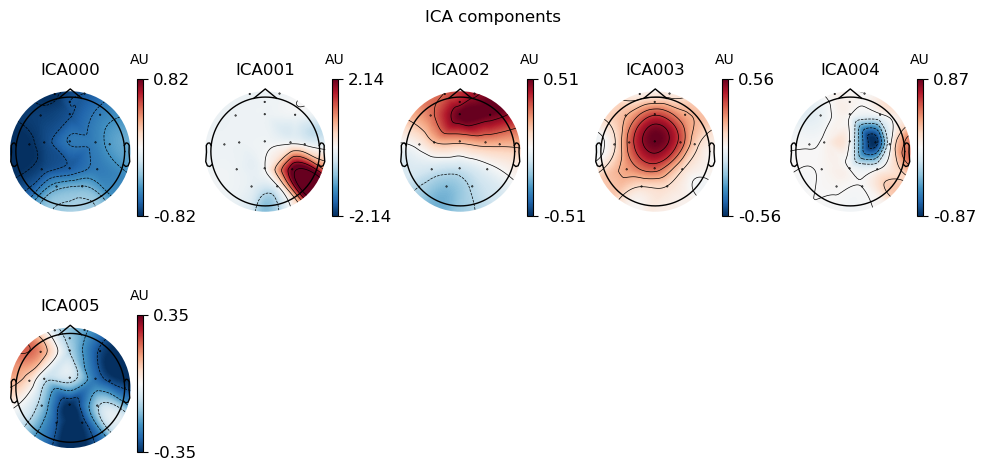

In [59]:
fig = ica.plot_components(colorbar=True)

#### Decompose signal using ICA, eliminate the noisy components and retirve the cleaned EEGs

In [ ]:
epoch_name = 'preop_rest'
preprocessor.apply_ica(epoch_name)

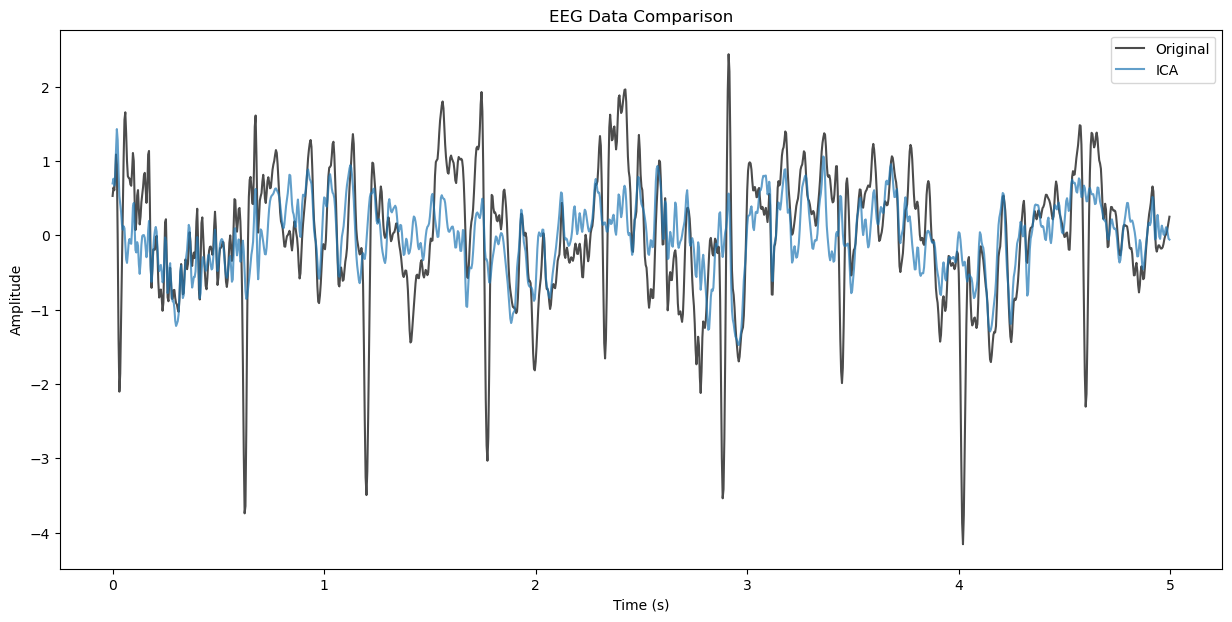

In [61]:
channel_index = 2

start_time_to_plot = 5
duration_to_plot = 5
end_time_to_plot = start_time_to_plot + duration_to_plot

original_eeg = preprocessor.eeg_with_rejected_noisy_segments[epoch_name][start_time_to_plot*sampling_freq:end_time_to_plot*sampling_freq, :]
corrected_eeg = preprocessor.corrected_eeg[epoch_name][start_time_to_plot*sampling_freq:end_time_to_plot*sampling_freq, :]

time_original = np.arange(original_eeg.shape[0]) / sampling_freq

# Plot the original EEG data
plt.figure(figsize=(15, 7))
plt.plot(time_original, original_eeg[:, channel_index], label='Original', color = 'k', alpha=0.7)

# Plot the downsampled EEG data
plt.plot(time_original, corrected_eeg[:, channel_index], label='ICA', alpha=0.7)

# plt.ylim([-5, 5])

plt.title('EEG Data Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

##### Time-frequency analysis of EEG after removing artifactual ICs

In [64]:
data_attribute_to_process = 'corrected_eeg'

data_to_process = preprocessor._check_and_get_attribute(data_attribute_to_process)
data_to_process = data_to_process[epoch_name]

# Create an MNE Info object with the properties of your data
ch_names = preprocessor.channel_names  # Update with real channel names
ch_types = ['eeg'] * 16 + ['misc'] * (data_to_process.shape[1] - 16)
sampling_freq = preprocessor.ds_sampling_frequency if preprocessor.ds_sampling_frequency is not None else preprocessor.sampling_frequency
info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)

# Transpose your data to the shape `num_channels x num_samples` to create the Raw object
raw_data_transposed = data_to_process.T
raw = mne.io.RawArray(raw_data_transposed, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

freqs = np.logspace(*np.log10([0.5, 55]), num=50)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = mne.time_frequency.tfr_multitaper(raw, freqs=freqs, time_bandwidth=6.0, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=3, n_jobs=1)

Creating RawArray with float64 data, n_channels=21, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


No baseline correction applied
No baseline correction applied


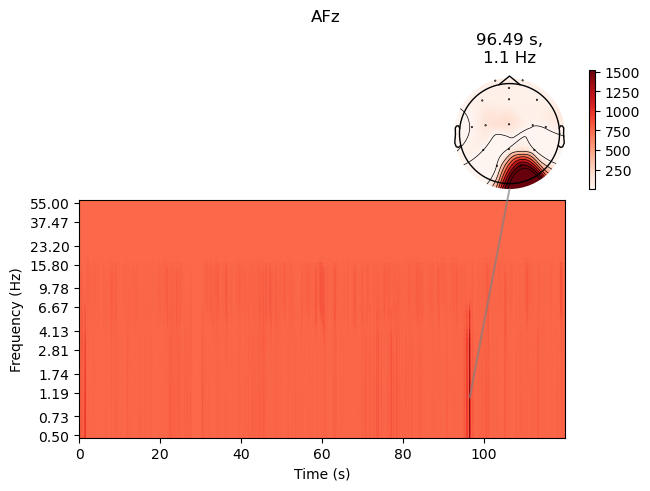

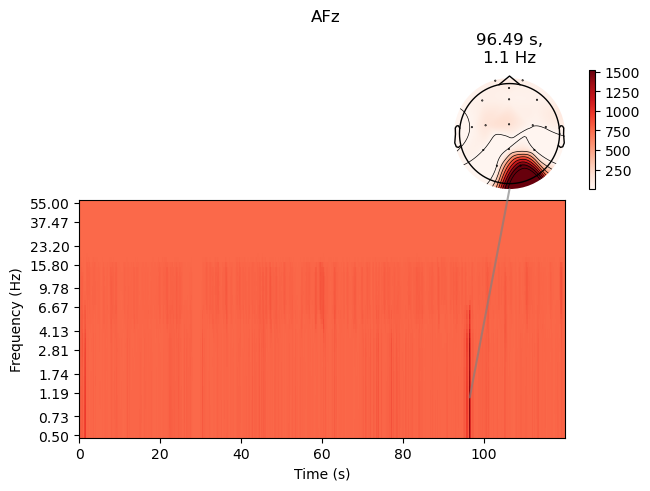

In [63]:
power.plot_joint(title=power.ch_names[3])